# **Midterm Exam: Time Series Analysis and Forecasting with Arima Model**

**Course Code: CSST104**

**Name: Simon B. Sancon**

**Section: BSCS-3B**


# **Importing Libraries**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns



# **1. Data Cleaning and Preparation**

**1.1 Loading the Dataset**

In [ ]:
google_play_data = pd.read_csv("googleplaystore.csv")
google_play_data.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


**1.2 Handling Missing Values**

In [ ]:
gplay_missing_count = google_play_data.isnull().sum()
print(gplay_missing_count)

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


In [ ]:
#Removing missing Values
gplay_no_missing = google_play_data.dropna()
print(gplay_no_missing.isnull().sum())
print(len(gplay_no_missing))

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64
9360


**1.3 Handling Duplicates**

In [ ]:
#Counting Duplicates
gplay_duplicates_counts = gplay_no_missing[gplay_no_missing["App"].duplicated() == True].count()
print(gplay_duplicates_counts)
#Dropping Duplicates
gplay_no_duplicates = gplay_no_missing.drop_duplicates(subset="App", keep="first")
print(len(gplay_no_duplicates))



App               1170
Category          1170
Rating            1170
Reviews           1170
Size              1170
Installs          1170
Type              1170
Price             1170
Content Rating    1170
Genres            1170
Last Updated      1170
Current Ver       1170
Android Ver       1170
dtype: int64
8190


**1.4 Handling Non Numerical Characters**

In [ ]:
gplay_clean = gplay_no_duplicates.copy()

#Removing Unnecessary Characters
def remove_character(column_name, character_to_remove):
  gplay_clean[column_name] = gplay_clean[column_name].str.replace(character_to_remove, "")

#For Converting the size from k to b as well as Mb to b
def convert_bytes(size_column):
  if isinstance(size_column, str):
    if "k" in size_column:
      return pd.to_numeric(size_column.replace("k", ""))* 1024
    elif "M" in size_column:
      return pd.to_numeric(size_column.replace("M", ""))* 1024 * 1024
  return size_column

gplay_clean["Size"] = gplay_clean["Size"].apply(convert_bytes)

remove_character("Installs", "+")
remove_character("Installs", ",")
remove_character("Price", "$")

gplay_size_varies = gplay_clean[gplay_clean["Size"] == "Varies with device"]
gplay_size_default = gplay_clean[gplay_clean["Size"] != "Varies with device"]

#Converting Columns to numeric
gplay_clean["Installs"] = pd.to_numeric(gplay_clean["Installs"])
gplay_clean["Reviews"] = pd.to_numeric(gplay_clean["Reviews"])
gplay_clean["Rating"] = pd.to_numeric(gplay_clean["Rating"])
gplay_clean["Price"] = pd.to_numeric(gplay_clean["Price"])

gplay_size_default["Installs"] = pd.to_numeric(gplay_size_default["Installs"])
gplay_size_varies["Installs"] = pd.to_numeric(gplay_size_varies["Installs"])
gplay_size_default["Size"] = pd.to_numeric(gplay_size_default["Size"])
gplay_size_default["Reviews"] = pd.to_numeric(gplay_size_default["Reviews"])
gplay_size_varies["Reviews"] = pd.to_numeric(gplay_size_varies["Reviews"])
gplay_size_default["Rating"] = pd.to_numeric(gplay_size_default["Rating"])
gplay_size_varies["Rating"] = pd.to_numeric(gplay_size_varies["Rating"])
gplay_size_default["Price"] = pd.to_numeric(gplay_size_default["Price"])
gplay_size_varies["Price"] = pd.to_numeric(gplay_size_varies["Price"])

gplay_size_default.head(5)



<ipython-input-176-2d6b6661bb05>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gplay_size_default["Installs"] = pd.to_numeric(gplay_size_default["Installs"])
<ipython-input-176-2d6b6661bb05>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gplay_size_varies["Installs"] = pd.to_numeric(gplay_size_varies["Installs"])
<ipython-input-176-2d6b6661bb05>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19922944.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14680064.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,9122611.2,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,26214400.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2936012.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# **2. Exploratory Data Analysis**

**2.1 Discriptive Statistics**

In [ ]:
gplay_clean_stats = gplay_clean.describe()
gplay_size_default_stats = gplay_size_default.describe()
gplay_size_varies_stats = gplay_size_varies.describe()
print(gplay_clean_stats)
print(gplay_size_default_stats)
print(gplay_size_varies_stats)

app_highest_install = gplay_clean.groupby("App")["Installs"].sum()
app_highest_review = gplay_clean.groupby("App")["Reviews"].sum()
app_highest_rating = gplay_clean.groupby("App")["Rating"].sum()
app_highest_install_score = app_highest_install.idxmax()
app_highest_review_score = app_highest_review.idxmax()
app_highest_rating_score = app_highest_rating.idxmax()

app_install_sum_default = gplay_size_default.groupby("App")["Installs"].sum()
app_install_sum_varies = gplay_size_varies.groupby("App")["Installs"].sum()
app_install_default_highest_score = app_install_sum_default.idxmax()
app_install_varies_highest_score = app_install_sum_varies.idxmax()

app_review_default_highest = gplay_size_default.groupby("App")["Reviews"].sum()
app_review_varies_highest = gplay_size_varies.groupby("App")["Reviews"].sum()
app_review_default_highest_score = app_review_default_highest.idxmax()
app_review_varies_highest_score = app_review_varies_highest.idxmax()

app_rating_default_highest = gplay_size_default.groupby("App")["Rating"].sum()
app_rating_varies_highest = gplay_size_varies.groupby("App")["Rating"].sum()
app_rating_default_highest_score = app_rating_default_highest.idxmax()
app_rating_varies_highest_score = app_rating_varies_highest.idxmax()

print("\noverall highest app install:", app_highest_install_score)
print("overall highest app reviews:", app_highest_review_score)
print("overall highest app rating:", app_highest_rating_score)

print("\nhighest install_size_default:", app_install_default_highest_score)
print("highest install_size_varies:", app_install_varies_highest_score)
print("highest reviews_size_default:", app_review_default_highest_score)
print("highest reviews_size_varies:", app_review_varies_highest_score)
print("highest rating_size_default:", app_rating_default_highest_score)
print("highest rating_size_varies:", app_rating_varies_highest_score)


            Rating       Reviews      Installs        Price
count  8190.000000  8.190000e+03  8.190000e+03  8190.000000
mean      4.173321  2.554354e+05  9.171613e+06     1.038342
std       0.536691  1.986309e+06  5.827170e+07    16.864040
min       1.000000  1.000000e+00  1.000000e+00     0.000000
25%       4.000000  1.260000e+02  1.000000e+04     0.000000
50%       4.300000  3.009500e+03  1.000000e+05     0.000000
75%       4.500000  4.391425e+04  1.000000e+06     0.000000
max       5.000000  7.815831e+07  1.000000e+09   400.000000
            Rating       Reviews          Size      Installs        Price
count  7021.000000  7.021000e+03  7.021000e+03  7.021000e+03  7021.000000
mean      4.160704  1.448960e+05  2.282453e+07  4.471804e+06     1.174222
std       0.559241  1.024428e+06  2.383585e+07  2.714908e+07    18.205355
min       1.000000  1.000000e+00  8.704000e+03  1.000000e+00     0.000000
25%       4.000000  8.400000e+01  5.138022e+06  1.000000e+04     0.000000
50%       4.3000

**2.2 Visualization**

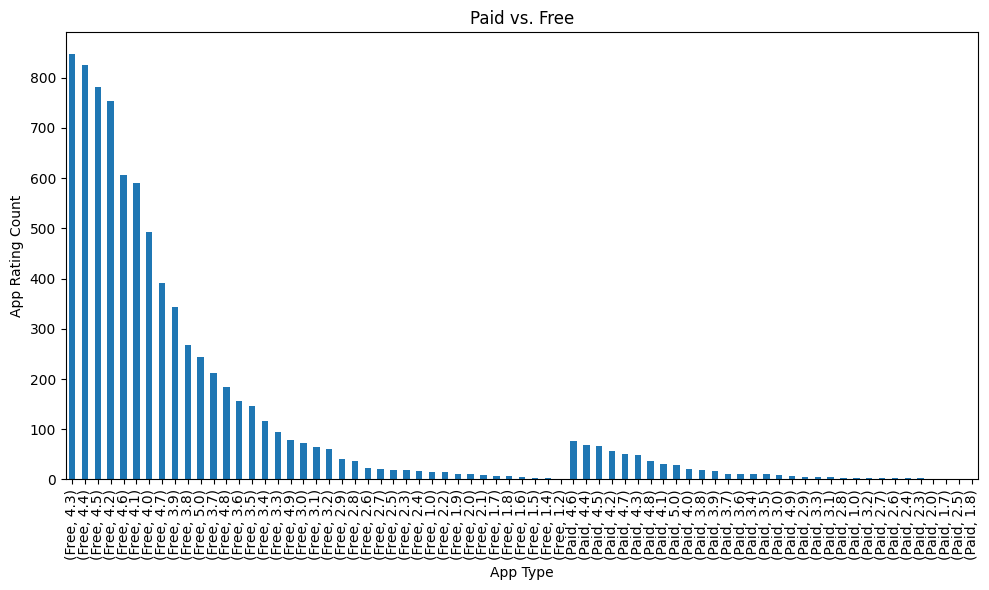

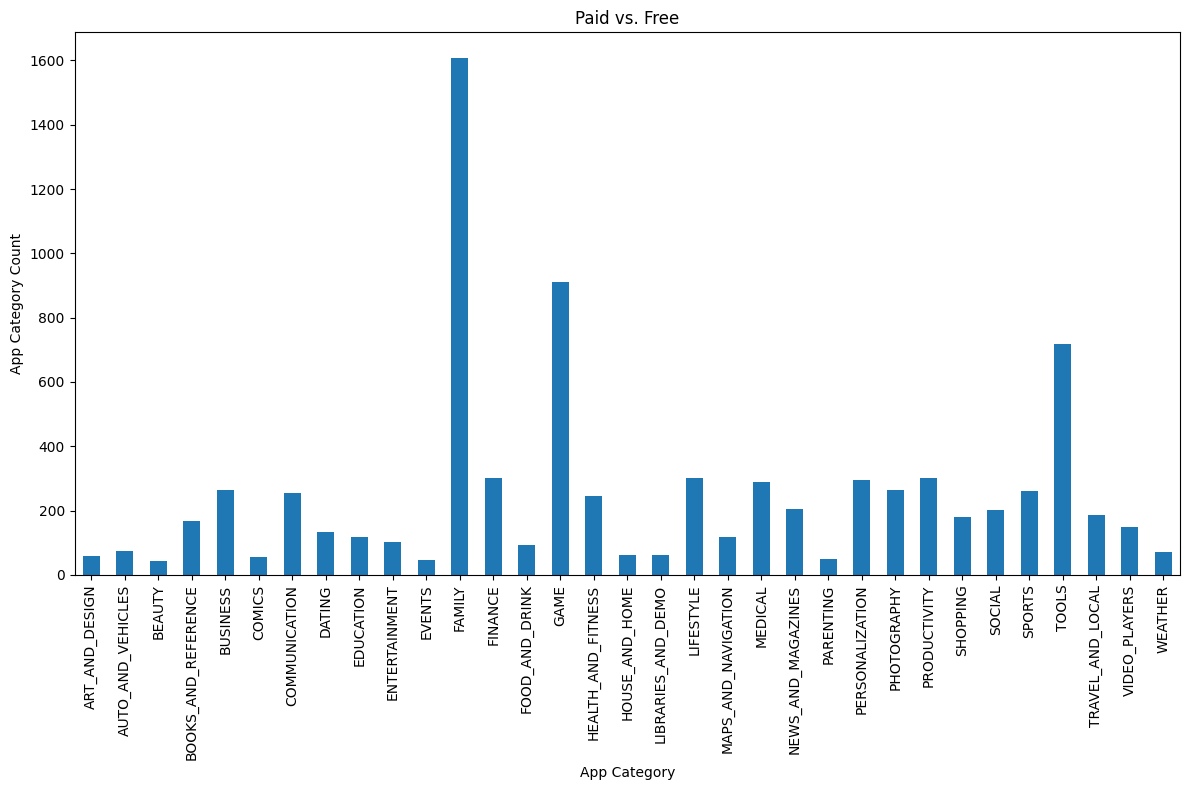

In [ ]:
app_rating_type = gplay_clean.groupby("Type")["Rating"].value_counts()
app_category_app = gplay_clean.groupby("Category")["App"].count()

# Paid vs Free Apps (Ratin Count)
plt.figure(figsize=(10, 6))
app_rating_type.plot(kind="bar")
plt.xlabel("App Type")
plt.ylabel("App Rating Count")
plt.title("Paid vs. Free")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Paid vs Free Apps per Category (Count)
plt.figure(figsize=(12, 8))
app_category_app.plot(kind="bar")
plt.xlabel("App Category")
plt.ylabel("App Category Count")
plt.title("Paid vs. Free")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# **3. Category Analysis**

**3.1 Groupby Operations**

In [ ]:
#Grouping Columns then Identifying the highest scorer
highest_category_rating_score = gplay_clean.groupby("Category")["Rating"].mean()
highest_category_review_score = gplay_clean.groupby("Category")["Reviews"].mean()
highest_category_rating = highest_category_rating_score.idxmax()
highest_category_review = highest_category_review_score.idxmax()
print("highest avearag category rating:",highest_category_rating,":", highest_category_rating_score.max())
print("highest avearag category review:",highest_category_review,":", highest_category_review_score.max())


highest avearag category rating: EVENTS : 4.435555555555555
highest avearag category review: SOCIAL : 1122795.4187192118


**3.2 Category Visualization**

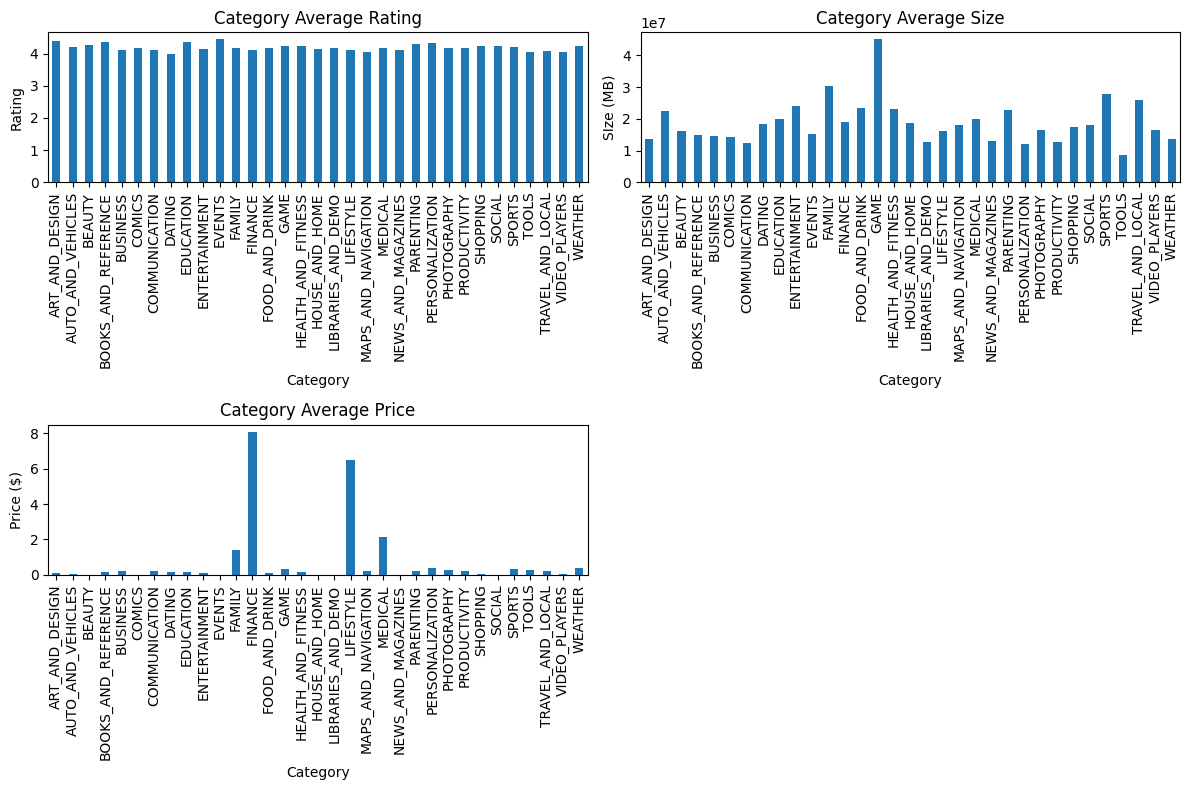

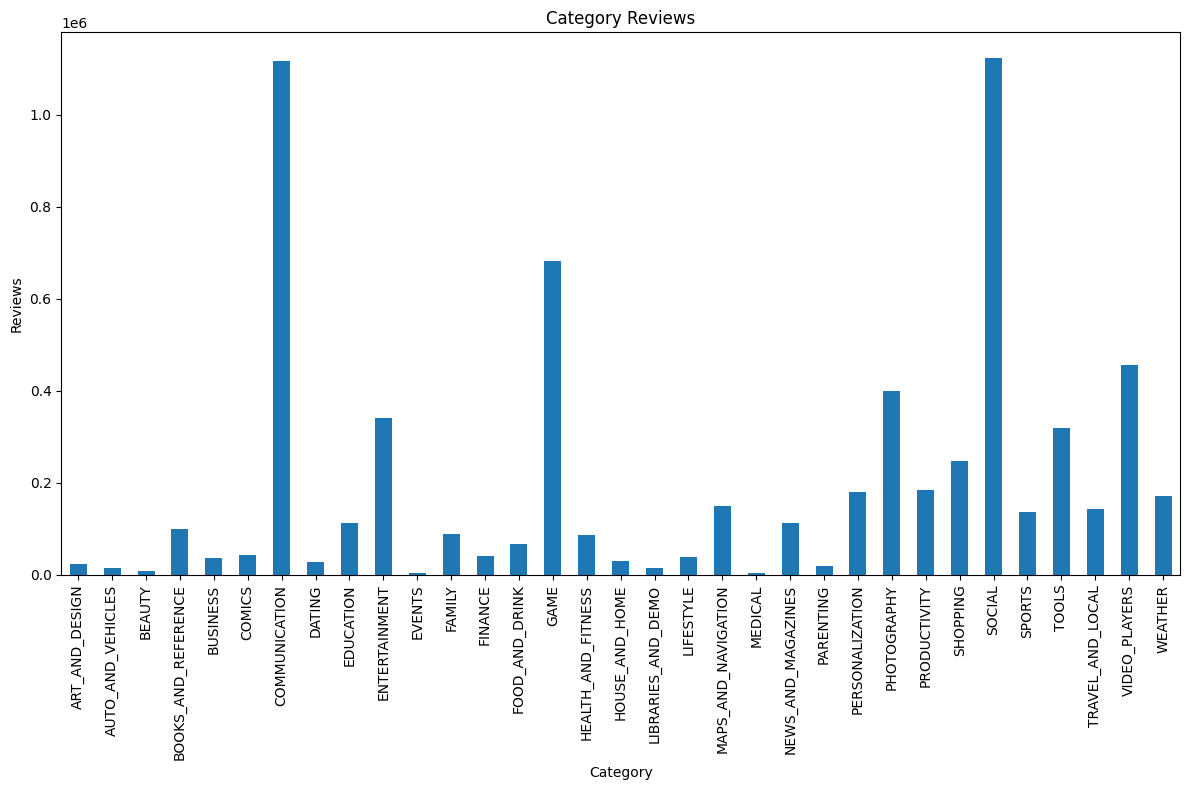

In [ ]:
app_category_rating = gplay_clean.groupby("Category")["Rating"]
app_category_size = gplay_size_default.groupby("Category")["Size"]
app_category_price = gplay_clean.groupby("Category")["Price"]
app_category_reviews = gplay_clean.groupby("Category")["Reviews"]
app_category_average_rating = app_category_rating.mean()
app_category_average_size = app_category_size.mean()
app_category_average_price = app_category_price.mean()
app_category_average_reviews = app_category_reviews.mean()

#Category and Rating
plt.subplot(2, 2, 1)
app_category_average_rating.plot(kind = "bar", figsize=(12,8))
plt.xlabel("Category")
plt.ylabel("Rating")
plt.title("Category Average Rating")
plt.xticks(rotation = 90)

#Category and Size in Mb
plt.subplot(2, 2, 2)
app_category_average_size.plot(kind = "bar", figsize=(12,8))
plt.xlabel("Category")
plt.ylabel("SIze (MB)")
plt.title("Category Average Size")
plt.xticks(rotation = 90)
plt.tight_layout()

#Category and Price in $
plt.subplot(2, 2, 3)
app_category_average_price.plot(kind = "bar", figsize=(12,8))
plt.xlabel("Category")
plt.ylabel("Price ($)")
plt.title("Category Average Price")
plt.xticks(rotation = 90)
plt.tight_layout()

#Category and Reviews
plt.figure( figsize=(12,8))
app_category_average_reviews.plot(kind = "bar")
plt.xlabel("Category")
plt.ylabel("Reviews")
plt.title("Category Reviews")
plt.xticks(rotation = 90)
plt.tight_layout()

plt.show()

# **4. Rating Prediction Model**

**4.1 Feature Selection**

In [ ]:
linear_y = gplay_size_default["Rating"]

linear_x = gplay_size_default.drop(["App",
                                          "Category",
                                          "Rating",
                                          "Type",
                                          "Content Rating",
                                          "Genres",
                                          "Last Updated",
                                          "Current Ver",
                                          "Android Ver"], axis = 1)

**4.2 Splitting the Dataset**

In [ ]:
linear_x_train, linear_x_test, linear_y_train, linear_y_test = train_test_split(linear_x, linear_y, test_size=0.2, random_state=42)

**4.3 Initialize Model/Fitting Model**

In [ ]:
model_linear = LinearRegression()
model_linear.fit(linear_x_train, linear_y_train)

LinearRegression()

**4.4 Making Predictions**

In [ ]:
gplay_predict_rating = model_linear.predict(linear_x_test)
print(linear_x_test)
print(gplay_predict_rating)

      Reviews         Size  Installs  Price
6285    63765   11534336.0   1000000    0.0
4305     2351   65011712.0    100000    0.0
4837    11408  100663296.0   1000000    0.0
6062      560    1782579.2     10000    0.0
6044        7     315392.0      5000    0.0
...       ...          ...       ...    ...
6142    81219    2726297.6  10000000    0.0
5284      322    7130316.8     50000    0.0
5130     2931     837632.0    100000    0.0
4444      589   29360128.0    100000    0.0
2492      124   45088768.0     10000    0.0

[1405 rows x 4 columns]
[4.14340917 4.20541546 4.24900497 ... 4.12846787 4.16261612 4.1814065 ]


**4.5 Model Evaluation**

In [ ]:
#Checking For Stationarity
r_squared = r2_score(linear_y_test, gplay_predict_rating)
print("R_Squared Value", r_squared)

mse= mean_squared_error(linear_y_test, gplay_predict_rating)
print("Mean Squared Error", mse)

R_Squared Value 0.005015539050947981
Mean Squared Error 0.3162173496302392


# **5.Trend Analysis**

**5.1 Converting Date to the Right Format**

In [ ]:
#Formatting the Date
gplay_clean["Last Updated"] = pd.to_datetime(gplay_clean["Last Updated"])
gplay_clean_sorted = gplay_clean.sort_values('Last Updated', ascending=True)
gplay_clean.head()


# Group data by month and calculate average rating, reviews and total installs
gplay_clean_monthly = gplay_clean.resample("M", on="Last Updated").agg({
    "Rating": "mean",
    "Installs": "mean",
    "Reviews" : "mean",
})

gplay_clean_monthly_sorted = gplay_clean_monthly.sort_index().dropna()
gplay_clean_monthly_sorted.head(10)


,Rating,Installs,Reviews
Last Updated,,,
2010-05-31,4.200000,1.000000e+05,1415.000000
2011-01-31,4.100000,5.000000e+04,207.000000
2011-03-31,4.100000,1.000000e+05,981.000000
2011-04-30,3.766667,1.700000e+06,13123.000000
2011-05-31,3.900000,1.000000e+02,7.000000
2011-06-30,4.300000,3.353333e+05,2683.666667
2011-07-31,4.500000,5.000000e+06,31621.000000
2011-09-30,3.700000,5.250000e+05,4936.000000
2011-10-31,3.100000,1.000000e+03,7.000000


**5.2 Visualization**

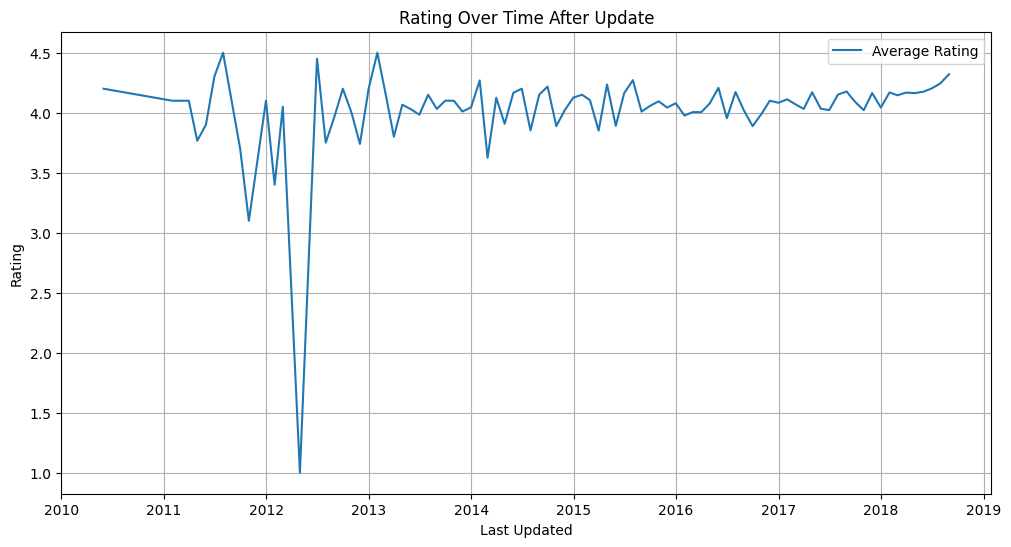

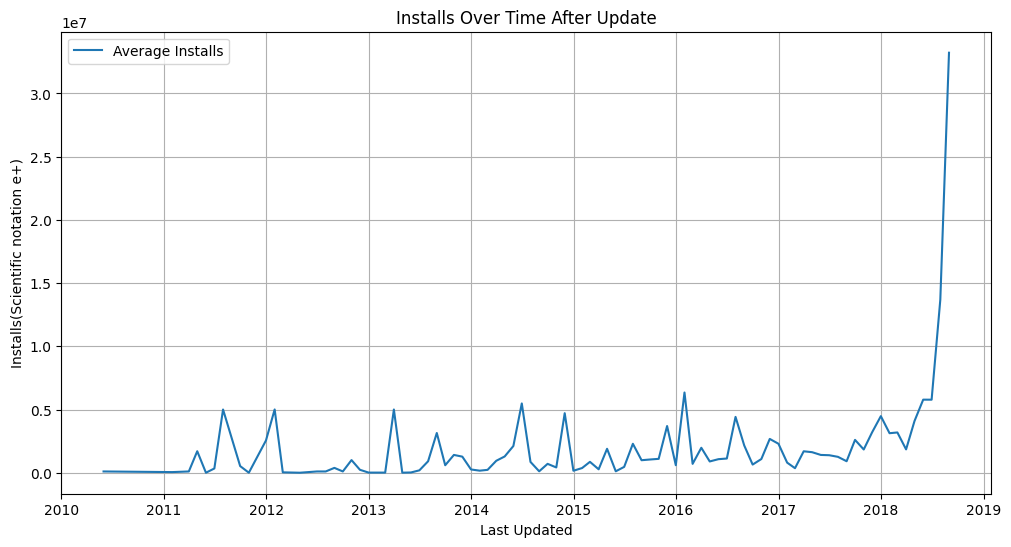

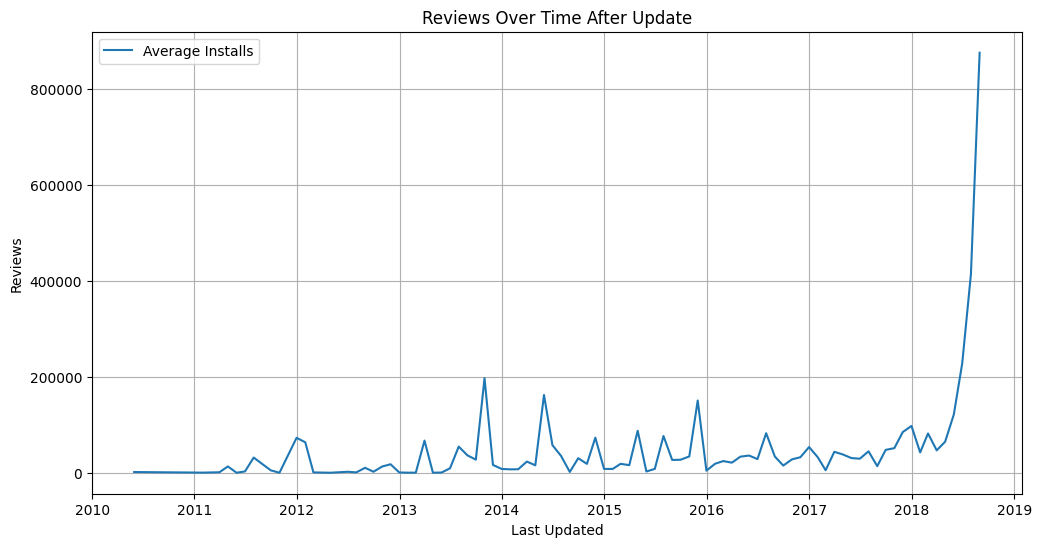

In [ ]:
# Visualize trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=gplay_clean_monthly_sorted, x="Last Updated", y="Rating", label="Average Rating")
plt.title("Rating Over Time After Update")
plt.xlabel("Last Updated")
plt.ylabel("Rating")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=gplay_clean_monthly_sorted, x="Last Updated", y="Installs", label="Average Installs")
plt.title("Installs Over Time After Update")
plt.xlabel("Last Updated")
plt.ylabel("Installs(Scientific notation e+)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=gplay_clean_monthly_sorted, x="Last Updated", y="Reviews", label="Average Installs")
plt.title("Reviews Over Time After Update")  # Adjust title accordingly
plt.xlabel("Last Updated")
plt.ylabel("Reviews")
plt.grid(True)
plt.legend()
plt.show()


**5.3 Stationarity Testing**

ADF Statistic: -2.1165217258302187
p-value: 0.23792323704195456


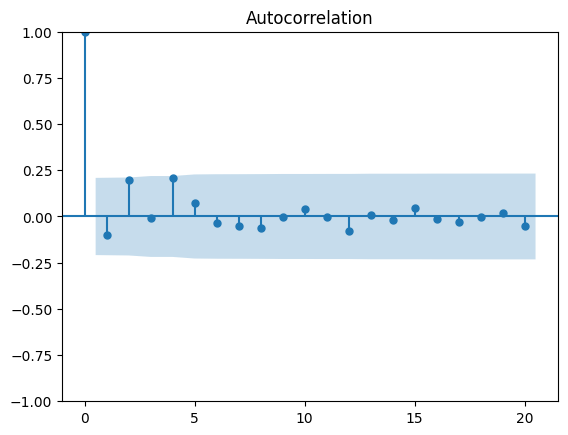

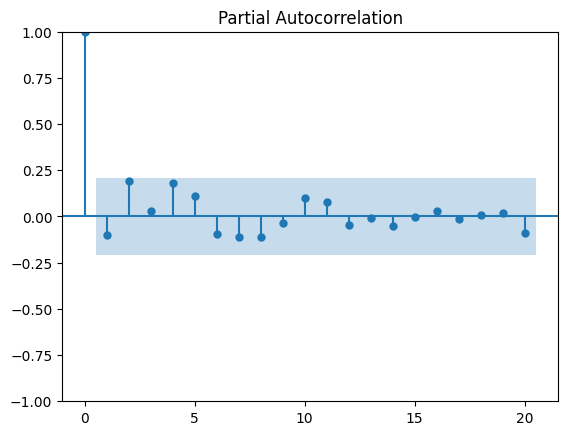

In [ ]:
app_rating = gplay_clean_monthly_sorted["Rating"]
# Perform ADF test on differenced series
adf_test = adfuller(app_rating)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

acf_original = plot_acf(app_rating)
pacf_riginal = plot_pacf(app_rating)

**5.4 Arima Model Identification**

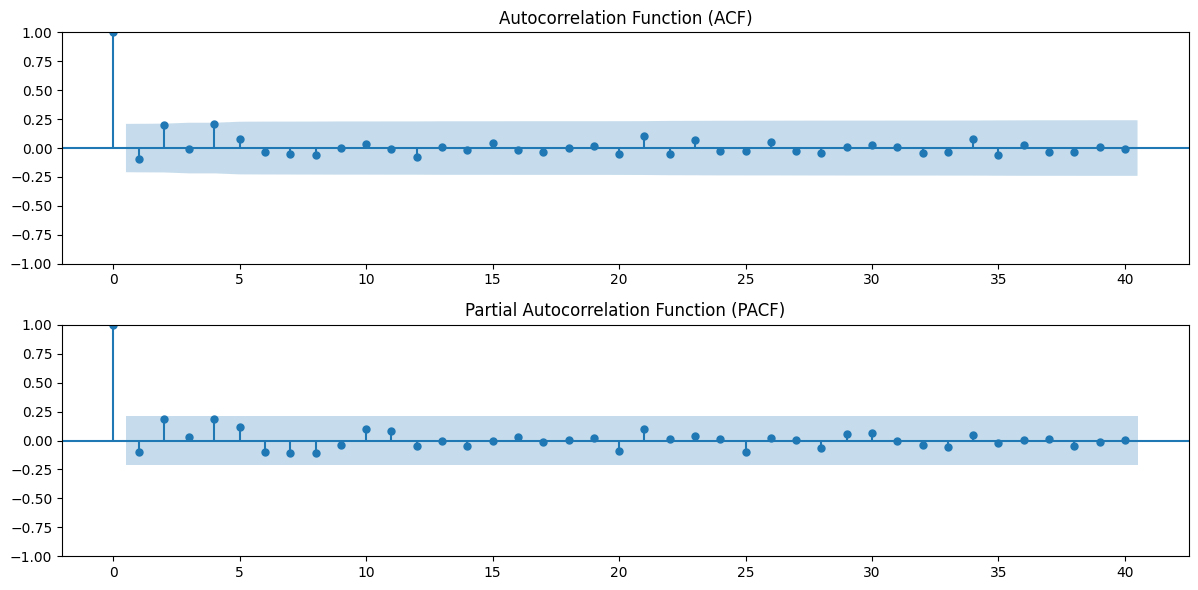

In [ ]:
# Generate ACF and PACF plots for the differenced series
plt.figure(figsize=(12, 6))

# ACF plot
ax1 = plt.subplot(211)
plot_acf(app_rating, ax=ax1, lags=40)
plt.title("Autocorrelation Function (ACF)")

# PACF plot
ax2 = plt.subplot(212)
plot_pacf(app_rating, ax=ax2, lags=40)
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

**5.5 Arima Model Fitting**

In [ ]:
arima_model = ARIMA(app_rating, order=(2, 1, 0))

results = arima_model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 Rating   No. Observations:                   88
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -47.718
Date:                Thu, 11 Apr 2024   AIC                            101.435
Time:                        05:54:11   BIC                            108.833
Sample:                             0   HQIC                           104.414
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8150      0.050    -16.219      0.000      -0.913      -0.716
ar.L2         -0.2886      0.062     -4.671      0.000      -0.410      -0.167
sigma2         0.1740      0.008     21.316      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


**5.6 Forecasting**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


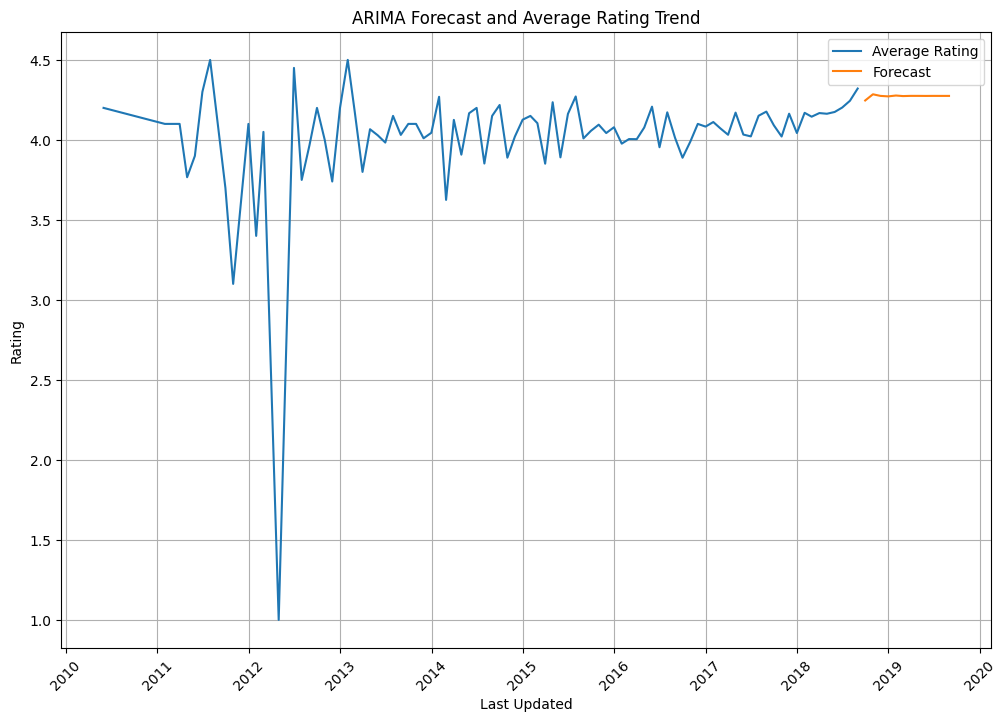

In [ ]:
# Forecasting
forecast_steps = 12
forecast_index = pd.date_range(start=gplay_clean_sorted["Last Updated"].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast = results.forecast(steps=forecast_steps)

# Plotting
plt.figure(figsize=(12, 8))

# Plot average rating trend
sns.lineplot(data=gplay_clean_monthly_sorted, x='Last Updated', y='Rating', label='Average Rating')

# Plot ARIMA forecast
plt.plot(forecast_index, forecast, label="Forecast")

# Customize plot
plt.xlabel("Last Updated")
plt.ylabel("Rating")
plt.title("ARIMA Forecast and Average Rating Trend")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show plot
plt.show()




# **6. Impact on Reviews in Ratings**

**6.1 Visualization**

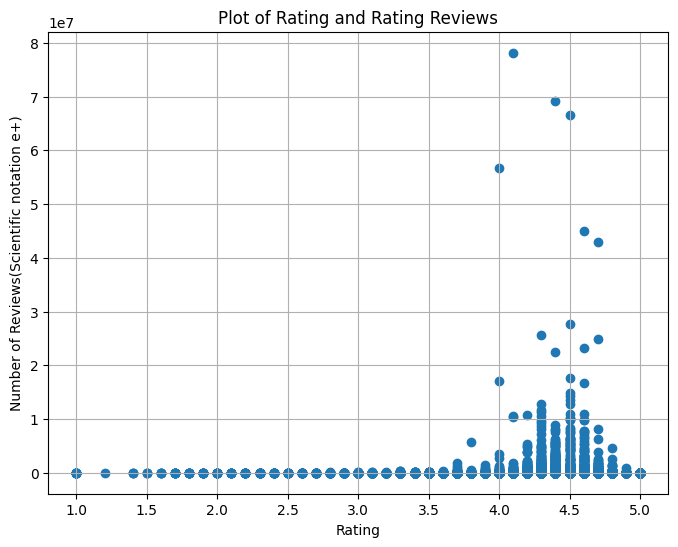

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(gplay_clean["Rating"], gplay_clean["Reviews"])
plt.xlabel("Rating")
plt.ylabel("Number of Reviews(Scientific notation e+)")
plt.title("Plot of Rating and Rating Reviews")
plt.grid(True)
plt.show()

**6.2 Over all Insights**

In [ ]:
"""
Over all Insights

2.1
Discriptive Statistics
overall highest app install: Facebook
overall highest app reviews: Facebook
overall highest app rating: 211:CK

highest install_size_default: Google News
highest install_size_varies: Facebook
highest reviews_size_default: Clash of Clans
highest reviews_size_varies: Facebook
highest rating_size_default: 211:CK
highest rating_size_varies: Accounting Quiz (AQ) Malaysia

2.2
Visualization
The Bar graph displays a more rating value count if the App type is free
Below this will be the interpretation of the leading categories which are:
-Family
-Game
-Tools

3.2
Category Visualization
The first plot include the rating per category
Beside this is the Average Size per Category with the Gaming leading
Below this 2 is the Category and Price with Finance and Lifesyle in the lead
And Below this all is the average Reviews per Category with Communication and Social in the lead

4.5
Model Evaluation
This pace is the for building the Predictive model Using Linear Regression
Performance Assesmenr below:
R_Squared Value 0.005015539050947981
Mean Squared Error 0.3162173496302392

5.2
Trend Analysis Visualization
The first graph shows a steady trend in the rating of 4.5 and above 3.5
Showing a sudden spike in the middle of 2012
Below this is the Average Installs overtime this shows a steady trend
until 2018 the trend spikes
This is also proved true in terms of review
Suggesting that more reviews more installs

5.6
Forecasting
Shows the forecasting for the average Rating Overtime

6.1
Visualization
Lastly The correlation Analysis
Showed in the scatterplot was a cluster of vast amount of reviews
in the higher values of both variables suggesting a direct correlation
of Installs and Reviews

"""

'\nOver all Insights\n\n2.1\nDiscriptive Statistics\noverall highest app install: Facebook\noverall highest app reviews: Facebook\noverall highest app rating: 211:CK\n\nhighest install_size_default: Google News\nhighest install_size_varies: Facebook\nhighest reviews_size_default: Clash of Clans\nhighest reviews_size_varies: Facebook\nhighest rating_size_default: 211:CK\nhighest rating_size_varies: Accounting Quiz (AQ) Malaysia\n\n2.2\nVisualization\nThe Bar graph displays a more rating value count if the App type is free\nBelow this will be the interpretation of the leading categories which are:\n-Family\n-Game\n-Tools\n\n3.2\nCategory Visualization\nThe first plot include the rating per category \nBeside this is the Average Size per Category with the Gaming leading\nBelow this 2 is the Category and Price with Finance and Lifesyle in the lead\nAnd Below this all is the average Reviews per Category with Communication and Social in the lead\n\n4.5\nModel Evaluation\nThis pace is the for 